In [1]:
import json
from enum import Enum
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

In [2]:
from graph import TYPES_OF_GRAPH

In [189]:
class Graph:
    def __init__(self, graph: dict, graph_type: TYPES_OF_GRAPH) -> None:
        if graph_type == TYPES_OF_GRAPH.MULTI:
            self.nx_graph = nx.MultiDiGraph()
        else:
            self.nx_graph = nx.DiGraph()
        self.type = graph_type
        self.graph_degrees = []
        for node in graph['nodes']:
            if type(node['response']) is list:
                self.nx_graph.add_node(node['id'], responses=node['response'])
            else:
                self.nx_graph.add_node(node['id'], responses=[node['response']])
        for link in graph['edges']:
            first = link['source']
            second = link['target']
            self.nx_graph.add_edges_from([(first, second, {"requests": link['request']})])

In [5]:
def get_edge_labels(graph):
    edge_labels = {}
    for u,v,d in graph.edges(data=True):
        if edge_labels.get((u,v,)) is not None:
            existing_value = edge_labels[(u,v,)]
            edge_labels[(u,v,)] = existing_value + ';\n' + d['requests']
        else:
            edge_labels[(u,v,)] = d['requests']
    return edge_labels

## Проверяем на изоморфизм

In [57]:
with open('./identical_except_numbering/ground_truth_graph.json', 'r') as f:
    ground_truth = json.load(f)

with open('./identical_except_numbering/generated_graph.json', 'r') as g:
    generated = json.load(g)

ground_truth_graph = Graph(ground_truth, TYPES_OF_GRAPH.DI)
G1 = ground_truth_graph.nx_graph
generated_graph = Graph(generated, TYPES_OF_GRAPH.DI)
G2 = ground_truth_graph.nx_graph

In [226]:
ground_truth_graph.nx_graph.edges

OutEdgeView([(1, 2), (1, 3), (2, 4), (3, 4), (4, 5), (4, 2), (5, 6), (6, 7)])

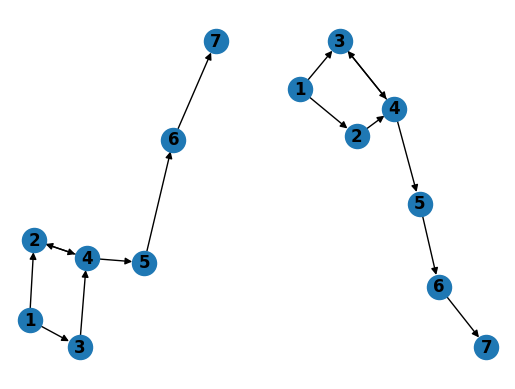

In [59]:
subax1 = plt.subplot(121)
nx.draw(ground_truth_graph.nx_graph, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw(generated_graph.nx_graph, with_labels=True, font_weight='bold')

In [227]:
do_mapping(ground_truth_graph.nx_graph, generated_graph.nx_graph)

Graphs are isomorphic and correct


{4: 4, 2: 3, 3: 2, 5: 5, 1: 1, 6: 6, 7: 7}

### Проверим на изоморфичность в случае, когда на ребрах несколько реплик, но графы одинаковы

In [228]:
with open('./identical_with_several_requests/ground_truth_graph.json', 'r') as f:
    ground_truth = json.load(f)

with open('./identical_with_several_requests/generated_graph.json', 'r') as g:
    generated = json.load(g)

In [229]:
ground_truth_graph = Graph(ground_truth, TYPES_OF_GRAPH.DI)
generated_graph = Graph(generated, TYPES_OF_GRAPH.DI)

In [232]:
from utils import do_mapping
do_mapping(ground_truth_graph.nx_graph, generated_graph.nx_graph)

Graphs are isomorphic and correct


{4: 4, 2: 3, 3: 2, 5: 5, 1: 1, 6: 6, 7: 7}

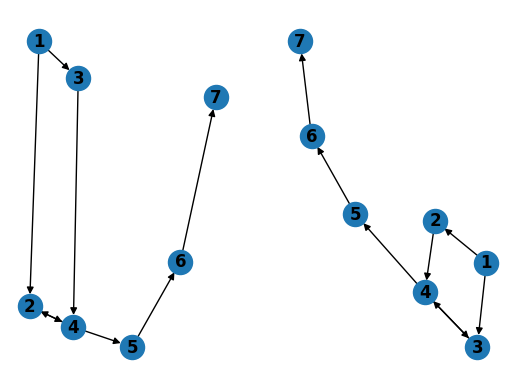

In [53]:

subax1 = plt.subplot(121)
nx.draw(ground_truth_graph.nx_graph, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw(generated_graph.nx_graph, with_labels=True, font_weight='bold')

### Проверка когда есть несоотвествие

In [11]:
with open('./nonidentical_graphs/ground_truth_graph.json', 'r') as f:
    ground_truth = json.load(f)

with open('./nonidentical_graphs/generated_graph.json', 'r') as g:
    generated = json.load(g)

In [15]:
ground_truth_graph = Graph(ground_truth, TYPES_OF_GRAPH.MULTI)
generated_graph = Graph(generated, TYPES_OF_GRAPH.MULTI)

G1 = ground_truth_graph.nx_graph
G2 = generated_graph.nx_graph

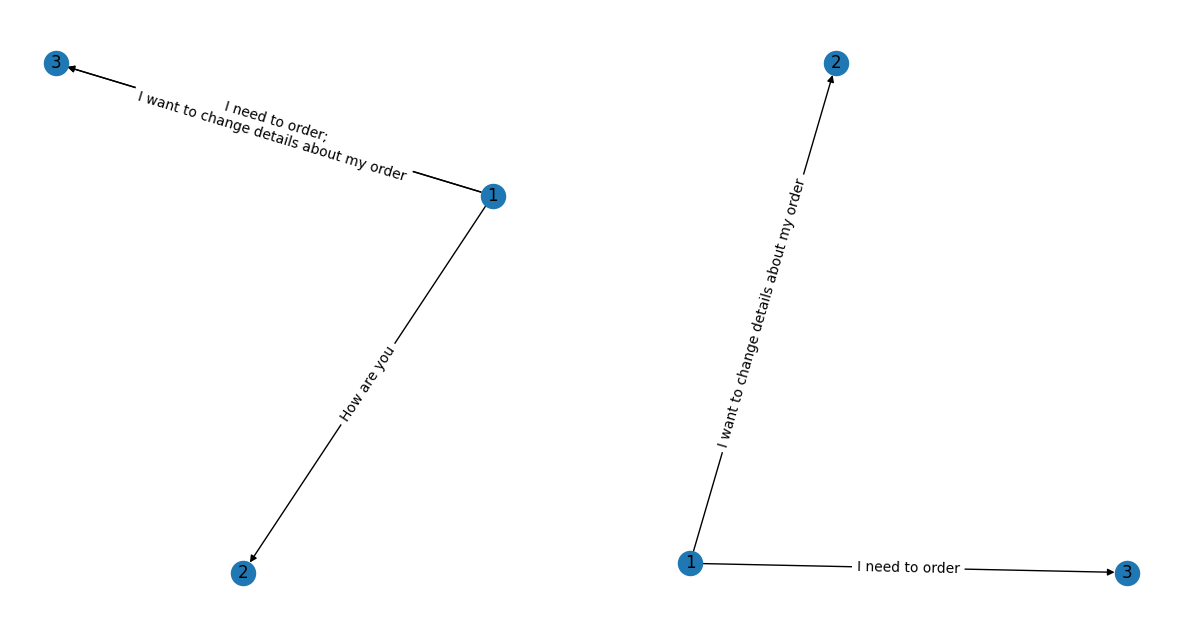

In [52]:
# pos = nx.spring_layout(G1)
plt.figure(figsize=(15,8))
subax1 = plt.subplot(121)
# nx.draw(G1, with_labels=True, font_weight='bold')
pos = nx.spring_layout(G1, k=5)
nx.draw(G1, pos, with_labels=True)
g1_edge_labels = get_edge_labels(G1)
nx.draw_networkx_edge_labels(G1, pos, edge_labels=g1_edge_labels, label_pos=0.5, font_size=10)

subax2 = plt.subplot(122)
pos2 = nx.spring_layout(G2, k=5)
nx.draw(G2, pos2, with_labels=True)
g2_edge_labels = get_edge_labels(G2)
nx.draw_networkx_edge_labels(G2, pos2, edge_labels=g2_edge_labels, label_pos=0.5, font_size=10)
plt.show()

In [243]:
do_mapping(G1, G2)

in g1 Node 3 is split into [3, 2] in g2
{3: [3, 2]}
{}
{1: 1, 2: None, 3: 3}


## Метрика

In [75]:
def collapse_multiedges(edges):
    collapsed_edges = {}
    for u, v, data in edges:
        key=f'{u}->{v}'
        if key not in collapsed_edges:
            collapsed_edges[key] = []
        collapsed_edges[key].append(*data.values())
    return collapsed_edges

In [83]:
def jaccard_edges(true_graph_edges, generated_graph_edges, verbose=False, return_matrix=True):
    true_graph_edges = collapse_multiedges(list(true_graph_edges))
    generated_graph_edges = collapse_multiedges(list(generated_graph_edges))

    jaccard_values = np.zeros((len(true_graph_edges), len(generated_graph_edges)))
    
    for idx1, (k1, v1) in enumerate(true_graph_edges.items()):
        for idx2, (k2, v2) in enumerate(generated_graph_edges.items()):
            value1 = set(v1).intersection(set(v2))
            value2 = set(v1).union(set(v2))
            jaccard_values[idx1][idx2] = len(value1) / len(value2)
            
            if verbose:
                print(k1, v1)
                print(k2, v2)
                print(value1, value2)
                print("___")
    if verbose:
        print(jaccard_values)
    max_jaccard_values = np.max(jaccard_values, axis=1)
    max_jaccard_indices = np.argmax(jaccard_values, axis=1)
    if return_matrix:
        return max_jaccard_values, max_jaccard_indices, jaccard_values
    return max_jaccard_values, max_jaccard_indices

In [348]:
def jaccard_nodes(true_graph_nodes, generated_graph_nodes, verbose=False, return_matrix=False):
    '''
    true_graph_nodes: Graph.nodes - вершины истинного графа
    generated_graph_nodes: nx.Graph.nodes - вершины сгенерированного графу
    формат вершин:
    (1, {"responses": ...})
    verbose: bool - печать отладочной информации
    '''
    jaccard_values = np.zeros((len(true_graph_nodes) + 1, len(generated_graph_nodes) + 1))
    for node1 in true_graph_nodes:
        for node2 in generated_graph_nodes:
            # print(node1)
            node1_id = node1[0]
            node2_id = node2[0]

            node1_responses = set(node1[1]['responses'])
            node2_responses = set(node2[1]['responses'])

            jaccard_nominator = node1_responses.intersection(node2_responses)
            jaccard_denominator = node1_responses.union(node2_responses)
            
            jaccard_values[node1_id][node2_id] = len(jaccard_nominator) / len(jaccard_denominator)

            if verbose:
                print(node1[1]['responses'])
                print(node2[1]['responses'])
                print(jaccard_nominator, jaccard_denominator)
                print("_____")
    if verbose:
        print(jaccard_values)
    max_jaccard_values = np.max(jaccard_values[1:], axis=1)
    max_jaccard_indices = np.argmax(jaccard_values[1:], axis=1)
    max_jaccard_indices =  max_jaccard_indices - np.ones(max_jaccard_indices.shape)
    np.place(max_jaccard_indices, max_jaccard_indices < 0, 0)
    max_jaccard_indices = max_jaccard_indices.astype(int)
    if return_matrix:
        return max_jaccard_values, max_jaccard_indices, jaccard_values[1:, 1:]
    return max_jaccard_values, max_jaccard_indices

In [58]:
list(G1.edges(data=True))

[(1, 3, {'requests': 'I need to order'}),
 (1, 3, {'requests': 'I want to change details about my order'}),
 (1, 2, {'requests': 'How are you'})]

In [82]:
jaccard_edges(G1.edges(data=True), G2.edges(data=True))

1->3 ['I need to order', 'I want to change details about my order']
1->3 ['I need to order']
___
1->3 ['I need to order', 'I want to change details about my order']
1->2 ['I want to change details about my order']
___
1->2 ['How are you']
1->3 ['I need to order']
___
1->2 ['How are you']
1->2 ['I want to change details about my order']
___
[[0.5 0.5]
 [0.  0. ]]


(array([0.5, 0. ]), array([0, 0]))

In [52]:
jaccard_nodes(G1.nodes(data=True), G2.nodes(data=True))

(array([0., 1., 0., 0.]), array([0, 1, 0, 0]))

## Дополнение графа

#### В случае корректного дополнения

In [316]:
with open('./correct_subgraph_metric_calc/initial_graph.json', 'r') as f:
    ground_truth = json.load(f)

with open('./correct_subgraph_metric_calc/gpt_response.json', 'r') as g:
    generated = json.load(g)

In [317]:
ground_truth_graph = Graph(ground_truth, TYPES_OF_GRAPH.MULTI)
generated_graph = Graph(generated, TYPES_OF_GRAPH.MULTI)

G1 = ground_truth_graph.nx_graph
G2 = generated_graph.nx_graph

In [319]:
do_mapping(G1, G2)

Graphs are isomorphic and correct


{2: 2, 4: 3, 5: 4, 6: 5, 1: 1, 3: 8, 7: 6, 8: 7}

In [320]:
values, indices, matrix_edges = jaccard_edges(G1.edges(data=True), G2.edges(data=True), verbose=False)

In [326]:
values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [327]:
indices

array([0, 2, 1, 5, 6, 3, 4, 5, 6, 7, 6, 9])

In [321]:
matrix

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [350]:
values, indices, matrix = jaccard_nodes(G1.nodes(data=True), G2.nodes(data=True), verbose=False, return_matrix=True)

In [352]:
values

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [351]:
matrix

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

In [324]:
edges1 = list(collapse_multiedges(G1.edges(data=True)).keys())
edges2 = list(collapse_multiedges(G2.edges(data=True)).keys())

mapping = {}

for i in range(matrix_edges.shape[0]):
    mapping[edges1[i]] = None
    for j in range (matrix_edges.shape[1]):
        if matrix_edges[i][j] > 0:
            node1_src, node1_trg = edges1[i].split('->')
            node2_src, node2_trg = edges2[j].split('->')
            # print(node1_src, node1_trg, node2_src, node2_trg)
            node1_src = G1.nodes[int(node1_src)]
            node2_src = G2.nodes[int(node2_src)]
            node1_trg = G1.nodes[int(node1_trg)]
            node2_trg = G2.nodes[int(node2_trg)]
            if node1_src['responses'] == node2_src['responses'] and node1_trg['responses'] != node2_trg['responses']:
                print('Two edges has the same source but different targets')
            elif node1_src['responses'] != node2_src['responses'] or node1_trg['responses'] != node2_trg['responses']:
                continue
            else:
                mapping[edges1[i]] = edges2[j]

In [323]:
mapping

{'1->2': '1->2',
 '2->3': '2->8',
 '2->4': '2->3',
 '3->2': '8->2',
 '3->7': '8->6',
 '4->5': '3->4',
 '4->6': '3->5',
 '5->2': '4->2',
 '5->7': '4->6',
 '6->2': '5->2',
 '6->7': '5->6',
 '7->8': '6->7'}

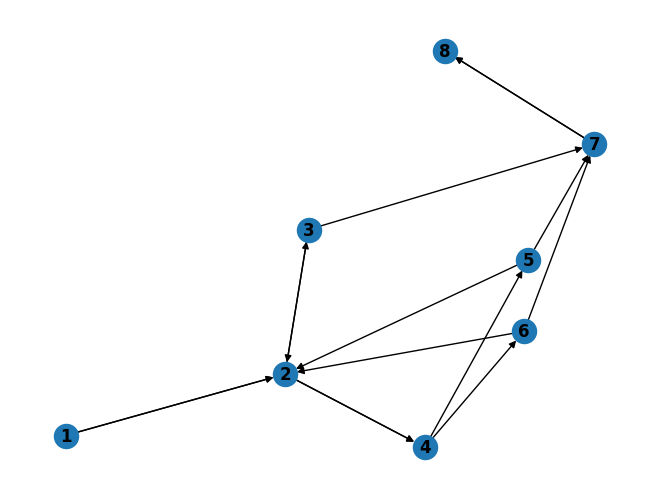

In [67]:

# subax1 = plt.subplot(121)
pos = nx.spring_layout(G1)
nx.draw(G1, pos, with_labels=True, font_weight='bold')
# subax2 = plt.subplot(122)
# nx.draw(G2, with_labels=True, font_weight='bold')

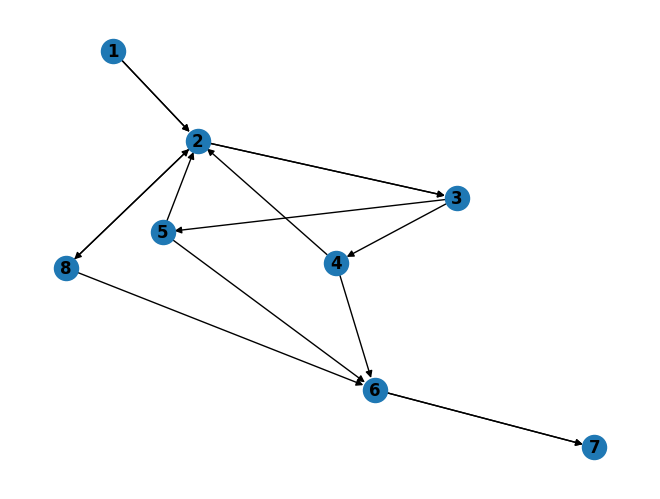

In [68]:
pos = nx.spring_layout(G2)
nx.draw(G2, pos, with_labels=True, font_weight='bold')

In [94]:
values, indices, matrix = jaccard_edges(G1.edges(data=True), G2.edges(data=True), verbose=False)

In [79]:
values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [80]:
indices

array([0, 2, 1, 5, 6, 3, 4, 5, 6, 7, 6, 9])

### В случае некорректного дополнения

In [190]:
with open('./incorrect_subgraph_metric_calc/initial_graph.json', 'r') as f:
    ground_truth = json.load(f)

with open('./incorrect_subgraph_metric_calc/gpt_response.json', 'r') as g:
    generated = json.load(g)

In [191]:
ground_truth_graph = Graph(ground_truth, TYPES_OF_GRAPH.MULTI)
generated_graph = Graph(generated, TYPES_OF_GRAPH.MULTI)

G1 = ground_truth_graph.nx_graph
G2 = generated_graph.nx_graph

In [107]:
values, indices, matrix = jaccard_edges(G1.edges(data=True), G2.edges(data=True), verbose=True)

1->2 ['I need to make an order', 'I want to order']
1->2 ['I need to make an order', 'I want to order']
{'I want to order', 'I need to make an order'} {'I want to order', 'I need to make an order'}
___
1->2 ['I need to make an order', 'I want to order']
2->3 ['Do you have War and Piece?', "Do you have Tolstoy's diaries?"]
set() {'I want to order', 'I need to make an order', "Do you have Tolstoy's diaries?", 'Do you have War and Piece?'}
___
1->2 ['I need to make an order', 'I want to order']
2->8 ['I need Crime and Punishment']
set() {'I want to order', 'I need to make an order', 'I need Crime and Punishment'}
___
1->2 ['I need to make an order', 'I want to order']
3->4 ['Yes']
set() {'I want to order', 'I need to make an order', 'Yes'}
___
1->2 ['I need to make an order', 'I want to order']
3->5 ['No']
set() {'I want to order', 'I need to make an order', 'No'}
___
1->2 ['I need to make an order', 'I want to order']
4->2 ['Yes, I also need a book Airplane']
set() {'I want to order', 'Y

In [108]:
values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [109]:
indices

array([ 0,  2,  1, 10,  8,  3,  4,  5,  6,  7,  8,  9])

In [300]:
edges1 = list(collapse_multiedges(G1.edges(data=True)).keys())
edges2 = list(collapse_multiedges(G2.edges(data=True)).keys())

mapping = {}

for i in range(matrix.shape[0]):
    mapping[edges1[i]] = None
    for j in range (matrix.shape[1]):
        if matrix[i][j] > 0:
            node1_src, node1_trg = edges1[i].split('->')
            node2_src, node2_trg = edges2[j].split('->')
            # print(node1_src, node1_trg, node2_src, node2_trg)
            node1_src = G1.nodes[int(node1_src)]
            node2_src = G2.nodes[int(node2_src)]
            node1_trg = G1.nodes[int(node1_trg)]
            node2_trg = G2.nodes[int(node2_trg)]
            if node1_src['responses'] == node2_src['responses'] and node1_trg['responses'] != node2_trg['responses']:
                print(node1_src,node2_src)
                print(node1_trg, node2_trg)
                print('oh')
            elif node1_src['responses'] != node2_src['responses'] or node1_trg['responses'] != node2_trg['responses']:
                print(node1_src,node2_src)
                print(node1_trg, node2_trg)
                print('hm')
            else:
                mapping[edges1[i]] = edges2[j]

{'responses': ['Added it to your cart. Anything else?']} {'responses': ['Added it to your cart. Anything else?']}
{'responses': ['Which books would you like to order?', 'What would you like to buy?']} {'responses': ['Okay, everything is done, you can go to cart and finish the order.']}
oh
{'responses': ['Added it to your cart. Anything else?']} {'responses': ['Okay. Anything else?']}
{'responses': ['Okay, everything is done, you can go to cart and finish the order.']} {'responses': ['Okay, everything is done, you can go to cart and finish the order.']}
hm


In [301]:
mapping

{'1->2': '1->2',
 '2->3': '2->8',
 '2->4': '2->3',
 '3->2': None,
 '3->7': None,
 '4->5': '3->4',
 '4->6': '3->5',
 '5->2': '4->2',
 '5->7': '4->6',
 '6->2': '5->2',
 '6->7': '5->6',
 '7->8': '6->7'}